# Praca domowa 4

## Import i preprocessing danych

In [1]:
import pandas as pd
import numpy as np

data = pd.read_stata("hcmst.dta")

num1 = "Q34"             # Ocena jakości związku
num2 = "ppeduc"          # Najwyzszy zdobyty poziom edukacji
num3 = "Q9"              # Wiek partnera
cat1 = "Q19"             # Czy mieszkacie ze sobą obecnie?
cat2 = "Q12"             # Polityczne preferencje partnera
label = "S1"             # Czy jesteście małżeństwem

data = data[[num1,num2,cat1,cat2,num3,label]].dropna()
data.rename(columns={'Q9':'partners_age','Q34':'rel_quality','ppeduc':'education','Q19':'living_together','Q12':'partner_politics'}, inplace=True)
data.head()

,rel_quality,education,living_together,partner_politics,partners_age,S1
1,Excellent,Masters degree,Yes,Leans Republican,52,"Yes, I am Married"
2,Good,Masters degree,Yes,Leans Democrat,45,"Yes, I am Married"
4,Excellent,Bachelors degree,Yes,Strong Democrat,59,"Yes, I am Married"
5,Good,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Undecided/Independent/Other,60,"Yes, I am Married"
6,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Leans Republican,67,"Yes, I am Married"


In [2]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'Refused':-1, 
            'Excellent':5, 
            "Good":4, 
            "Fair":3, 
            "Poor":2, 
            "Very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'No formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':9,
            'Some college, no degree':10,
            'Bachelors degree':11,
            'Masters degree':12,
            'Associate degree':13,
            'Professional or Doctorate degree':14
        })
        
    if column_name == 'partner_politics':
         data[column_name] = data[column_name].map({
            'Strong Republican' :1,
            'Not Strong Republican' :2,
            'Leans Republican' :3,
            'Undecided/Independent/Other' :4,
            'Leans Democrat' :5,
            'Not Strong Democrat' :6,   
            'Strong Democrat' :7
           })
    
    if column_name == 'living_together':
         data[column_name] = data[column_name].map({
            'Refused' :-1,
            'Yes' :1,
            'No' :2
         })
            
    if column_name != 'rel_quality' and column_name != 'education' and column_name != 'partner_politics' and column_name != 'living_together' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
             
    else:
        pass

In [3]:
from sklearn.model_selection import train_test_split

data = data.dropna()

y = data.loc[:,'S1']
X = data.loc[:, data.columns != 'S1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1851, 5), (912, 5), (1851,), (912,))

## Wyjaśniany model

In [4]:
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = random_forest.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.8629385964912281


### Wykres BreakDown

In [5]:
import waterfall_chart

def plot_breakdown(data, model, sample, feature_list):
    
    X_temp = data.copy()
    probabilities = []
    deltas = []

    # obliczenie sredniej odpowiedzi dla calego zbioru:
    temp_results = []
    
    for k in range(len(X_temp)):
        prob_single_sample = model.predict_proba(X_temp.iloc[[k]])
        temp_results.append(prob_single_sample[0][1])
        
    mean_prob = np.mean(temp_results)
    probabilities.append(mean_prob)
    deltas.append(probabilities[0])
    
    # obliczanie sredniej odpowiedzi dla ustalonych kolejnych zmiennych:
    
    for i in range(len(feature_list)):
        X_temp.loc[:,feature_list[i]] = int(sample[feature_list[i]]) 
        temp_results = []
        
        for j in range(len(X_temp)):
            prob_single_sample = model.predict_proba(X_temp.iloc[[j]])
            temp_results.append(prob_single_sample[0][1])
        
        mean_prob = np.mean(temp_results)
        probabilities.append(mean_prob)
        
        deltas.append(probabilities[i+1]-probabilities[i])
    
    waterfall_chart.plot(['base'] + feature_list, deltas, Title = "Models mean response",
                         net_label='End result', formatting='{:,.2f}')

    return

### Wykres LIME

In [76]:
from scipy.stats import truncnorm
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
import pydotplus
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def generate_local(data,sample,sigma,N):
    
    features = list(data)
    X_temp = pd.DataFrame(columns=features)
    
    for i in range(len(features)):
        minval = np.min(data[features[i]])
        maxval = np.max(data[features[i]])
        mean = sample[features[i]]
        perturbed_values = get_truncated_normal(mean,sigma,minval,maxval).rvs(size=N)
        X_temp[features[i]] = list(np.int_(perturbed_values))
    
    return X_temp


# ----------------- 

def plot_LIME(blackbox_model, data, sample, sg, N):
    
    X_local = generate_local(data, sample, sg, N)
    
    Y_pred_local = blackbox_model.predict_proba(X_local)[:,1]
    
    # WhiteBox model
    whitebox_model = DecisionTreeRegressor(max_depth=2)
    whitebox_model.fit(X_local, Y_pred_local)
    
    dot_data = StringIO()
    export_graphviz(whitebox_model, out_file=dot_data,  
                filled=True, rounded=True,feature_names=list(X_local),
                special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    return Image(graph.create_png())


## Przykłady

## 1.

In [134]:
single_couple = X_train.sample()
single_couple

,rel_quality,education,living_together,partner_politics,partners_age
1115,5.0,5.0,1,4.0,20


In [135]:
# sprawdzenie, jaka jest odpowiedź dla danej próbki w zbiorze danych

data.loc[single_couple.iloc[0].name].reset_index()

,index,1115
0,rel_quality,5.0
1,education,5.0
2,living_together,1.0
3,partner_politics,4.0
4,partners_age,20.0
5,S1,0.0


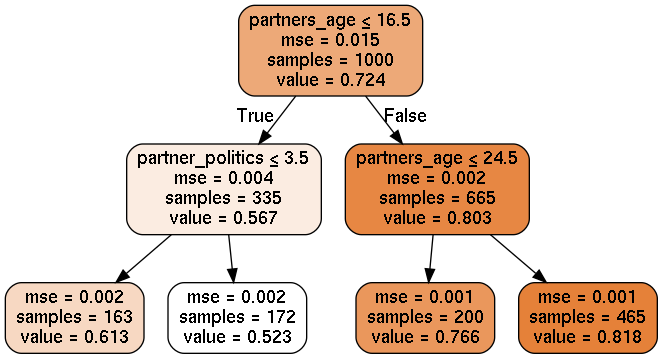

In [136]:
plot_LIME(random_forest, X_train, single_couple, 20, 1000)

### Porównanie z wykresem BreakDown

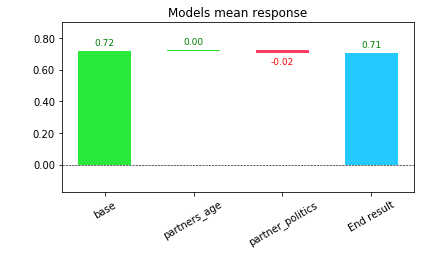

In [137]:
plot_breakdown(X_train, random_forest, single_couple, ['partners_age','partner_politics'])

----------------------------------

In [101]:
single_couple = X_train.sample()
single_couple

,rel_quality,education,living_together,partner_politics,partners_age
1444,5.0,10.0,1,3.0,58


In [102]:
# sprawdzenie, jaka jest odpowiedź dla danej próbki w zbiorze danych

data.loc[single_couple.iloc[0].name].reset_index()

,index,1444
0,rel_quality,5.0
1,education,10.0
2,living_together,1.0
3,partner_politics,3.0
4,partners_age,58.0
5,S1,1.0


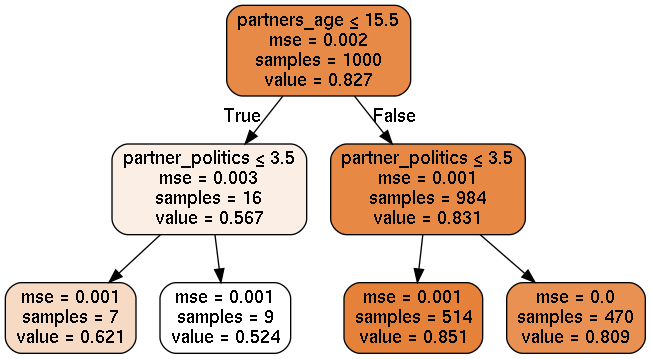

In [103]:
plot_LIME(random_forest, X_train, single_couple, 20, 1000)

### Porównanie z wykresem Break Down

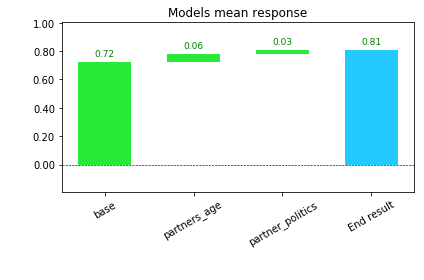

In [104]:
plot_breakdown(X_train, random_forest, single_couple, ['partners_age','partner_politics'])

## Wnioski

W obu przypadkach wykresy LIME wskazały na te same dwie cechy jako te mające największy wpływ na wynik - również wartości rozdzielające okazały się bardzo podobne.

W pierwszym przypadku decydującą cechą okazał się młody wiek, czego nie odzwierciedla wykres Breakdown, który w tym przypadku jest mało interesujący.

Za drugim razem już sam wiek sugerował zdecydowaną odpowiedź modelu w kierunku odpowiedzi "True". Nie inaczej wygląda to na wykresie Breakdown - tak jak wcześniej, wiek partnera silnie sugeruje odpowiedź pozytywną, a poglądy polityczne dodają jeszcze więcej pewności.

Interesujące jest to, że ponieważ ustaliliśmy tak mało podziałów drzewa, ograniczamy się bardzo jeśli chodzi o liczbę cech których wpływ na model badamy. W poprzedniej pracy domowej cechą mającą zazwyczaj istotny wpływ na odpowiedź modelu było wspólne mieszkanie, które na wykresach LIME nie pojawiło się ani razu. 